In [1]:
import os
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

load_dotenv()

gemini_api_key = os.getenv("GEMINI_API_KEY")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=gemini_api_key)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",api_key=gemini_api_key)

c:\AI\langgraph-end-to-end\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [3]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [4]:
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [5]:
search = DuckDuckGoSearchRun()

In [6]:
tools = [add,divide,multiply,search]

In [7]:
llm_with_tools = llm.bind_tools(tools)

In [8]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
     

In [9]:
def reasoner(state: MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [11]:
builder = StateGraph(MessagesState)

builder.add_node("reasoner",reasoner)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"reasoner")

builder.add_conditional_edges(
    "reasoner",
    tools_condition,
)

builder.add_edge("tools","reasoner")
react_graph = builder.compile()

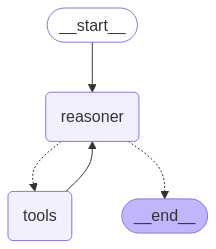

In [12]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
messages = HumanMessage(content="what is 2 times of narendramodi's age?")

In [14]:
messages = react_graph.invoke({"messages":messages})

In [15]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (1647355e-5b83-4232-96b1-2a7c57d75b82)
 Call ID: 1647355e-5b83-4232-96b1-2a7c57d75b82
  Args:
    query: narendra modi age
================================= Tool Message =================================
Name: duckduckgo_search

Narendra Modi (born September 17, 1950, Vadnagar, India) is an Indian politician and government official who rose to become a senior leader of the Bharatiya Janata Party (BJP). In 2014 he led his party to victory in elections to the Lok Sabha (lower chamber of the Indian parliament), after which he was sworn in as prime minister of India.Prior to that he had served (2001-14) as chief ... Learn about Narendra Modi, the Prime Minister of India since 2014, who was born on 17th September 1950. Find out his personal life, education, pol

In [19]:
messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]

In [20]:
messages = react_graph.invoke({"messages": messages})

In [21]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (80ca6128-2c49-4e48-a4f0-5a261b37ee08)
 Call ID: 80ca6128-2c49-4e48-a4f0-5a261b37ee08
  Args:
    query: current age of Elon Musk
================================= Tool Message =================================
Name: duckduckgo_search

#1 Elon Musk on the 2025 Billionaires #1 Elon Musk on the 2025 Billionaires. Subscribe To Newsletters. ... Age 53 Source of Wealth Tesla, SpaceX, Self Made Self-Made Score 8 Philanthropy Score 1 On 53rd Birthday, Elon Musk Shares 30-Year-Old Picture Of Himself. See Post Elon Musk was born to Errol and Maye Musk in Pretoria, South Africa, on June 28, 1971. All figures are current as of April 1, 2025. Key Takeaways. Elon Musk, CEO of Tesla, is the richest person in the world, with a net wort

In [38]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [39]:
get_stock_price("BAJFINANCE.NS")

8822.25

In [41]:
tools = [add, multiply, divide, search, get_stock_price]

In [42]:
llm_with_tools = llm.bind_tools(tools)

In [43]:
def reasoner(state):
    query = state["query"]
    messages = state["messages"]

    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [44]:
class GraphState(TypedDict):
    query: str
    finance: str
    final_answer: str
    messages: Annotated[list[AnyMessage], operator.add]

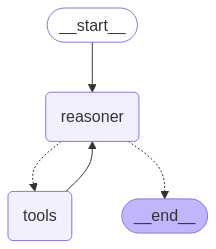

In [45]:
workflow = StateGraph(GraphState)

workflow.add_node("reasoner",reasoner)
workflow.add_node("tools",ToolNode(tools))

workflow.add_edge(START,"reasoner")
workflow.add_conditional_edges(
    "reasoner",
    tools_condition,
)
workflow.add_edge("tools","reasoner")
react_graph = workflow.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
response = react_graph.invoke({"query": "which Stock price is high ITC Limited or Bajaj Finance Limited?", "messages": []})

In [59]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

which Stock price is high ITC Limited or Bajaj Finance Limited?  
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (c7eae8a9-fe04-4c83-ad95-5904d6601ba2)
 Call ID: c7eae8a9-fe04-4c83-ad95-5904d6601ba2
  Args:
    ticker: ITC.NS
  get_stock_price (ccba7609-bb86-484f-8f26-784424210a22)
 Call ID: ccba7609-bb86-484f-8f26-784424210a22
  Args:
    ticker: BAJFINANCE.NS
================================= Tool Message =================================
Name: get_stock_price

412.55
================================= Tool Message =================================
Name: get_stock_price

8822.25
================================ Human Message =================================

which Stock price is high ITC Limited or Bajaj Finance Limited?  
================================== Ai Message ==================================

Bajaj Finance Limited is higher.
